# March Machine Learning Mania 2021 - NCAAW - Spread
# Predict the margin of victory in the 2021 women's tournament

This is my model that gave me first place on the NCAAW Spread Competition. There isn't really much to see here, except for a twist at the end. It's simple mapping from my probabilities in the main contest to spreads based on the historical data included.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Start by loading past Tournament results and my NCAAW probabilites without finals flipped and no clipping applied. Compute the win margins with the right signs (lower TeamID first).

In [2]:
from google.colab import files
uploaded=files.upload()

Saving WNCAATourneyDetailedResults.csv to WNCAATourneyDetailedResults.csv


In [3]:
from google.colab import files
uploaded=files.upload()

Saving submit_stage1_elo_tuned.csv to submit_stage1_elo_tuned.csv


In [4]:
tourney_results = pd.read_csv("WNCAATourneyDetailedResults.csv")
tourney_results = tourney_results.assign(Margin=lambda x: 
                                         np.sign(x.LTeamID - x.WTeamID) * (x.WScore - x.LScore))
prob_df = pd.read_csv("submit_stage1_elo_tuned.csv")

Check that the margins and especially their signs look good.

In [5]:
tourney_results[["Season", "WTeamID", "LTeamID", "WScore", "LScore", "Margin"]].head(20)

,Season,WTeamID,LTeamID,WScore,LScore,Margin
0,2010,3124,3201,69,55,14
1,2010,3173,3395,67,66,1
2,2010,3181,3214,72,37,35
3,2010,3199,3256,75,61,14
4,2010,3207,3265,62,42,20
5,2010,3208,3408,64,59,5
6,2010,3211,3314,82,76,6
7,2010,3234,3353,70,63,7
8,2010,3246,3251,83,77,6
9,2010,3261,3216,60,39,-21


Split the ID from the stage 1 main competition submission file to have Season, T1_TeamID, and T2_TeamID. We will later merge on these keys.

In [6]:
def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))


for ii, row in prob_df.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    prob_df.loc[ii, "Season"] = year
    prob_df.loc[ii, 'T1_TeamID'] = t1
    prob_df.loc[ii, 'T2_TeamID'] = t2
prob_df["Season"] = prob_df["Season"].astype(int)
prob_df["T1_TeamID"] = prob_df["T1_TeamID"].astype(int)
prob_df["T2_TeamID"] = prob_df["T2_TeamID"].astype(int)
prob_df.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2015_3106_3107,0.078635,2015,3106,3107
1,2015_3106_3110,0.092004,2015,3106,3110
2,2015_3106_3113,0.012859,2015,3106,3113
3,2015_3106_3114,0.068584,2015,3106,3114
4,2015_3106_3116,0.030511,2015,3106,3116


Also add T1/2_TeamID to the tournament results.

In [7]:
for ii, row in tourney_results.iterrows():
    t1_id, t2_id = row.WTeamID, row.LTeamID
    if t1_id > t2_id:
        t2_id, t1_id = t1_id, t2_id
    tourney_results.loc[ii, "T1_TeamID"] = t1_id
    tourney_results.loc[ii, "T2_TeamID"] = t2_id
    tourney_results.loc[ii, "Margin"] = row.Margin
tourney_results["T1_TeamID"] = tourney_results["T1_TeamID"].astype(int)
tourney_results["T2_TeamID"] = tourney_results["T2_TeamID"].astype(int)
tourney_results.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Margin,T1_TeamID,T2_TeamID
0,2010,138,3124,69,3201,55,N,0,28,57,...,17,19,12,18,4,1,18,14,3124,3201
1,2010,138,3173,67,3395,66,N,0,23,59,...,18,26,8,8,8,6,22,1,3173,3395
2,2010,138,3181,72,3214,37,H,0,26,57,...,10,21,4,16,6,4,20,35,3181,3214
3,2010,138,3199,75,3256,61,H,0,25,63,...,16,21,13,16,5,4,24,14,3199,3256
4,2010,138,3207,62,3265,42,N,0,24,68,...,16,22,9,10,3,4,12,20,3207,3265
5,2010,138,3208,64,3408,59,N,0,21,50,...,17,17,11,12,11,3,20,5,3208,3408
6,2010,138,3211,82,3314,76,H,0,36,75,...,17,31,15,18,12,5,16,6,3211,3314
7,2010,138,3234,70,3353,63,N,0,19,44,...,11,18,13,13,10,2,21,7,3234,3353
8,2010,138,3246,83,3251,77,H,0,25,49,...,17,21,8,22,8,1,25,6,3246,3251
9,2010,138,3261,60,3216,39,N,0,18,56,...,11,25,12,17,7,5,20,-21,3216,3261


And then merge the stage1 submission with the tournament results.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


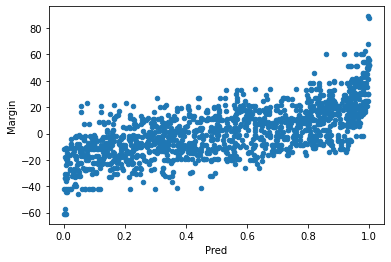

In [8]:
merged = prob_df.merge(tourney_results, on=["T1_TeamID", "T2_TeamID"])
merged.plot("Pred", "Margin", kind="scatter");

Looks noisy but the trend is right. At this point I decided not to find a functional form a fit a spline but thought about taking a windowed average. How large a window? Well that led me to using KNN and tuning k via GridSearchCV.

In [9]:
knn = KNeighborsRegressor()
param_grid = dict(n_neighbors=np.arange(1, 50))
clf = GridSearchCV(knn, param_grid)
clf.fit(merged.Pred.to_numpy().reshape(-1, 1), merged.Margin)
clf.best_index_

37

And now use the best model with k=37 to predict. This is what I submitted and gave me first place.

In [10]:
from google.colab import files
uploaded=files.upload()

Saving elo_2021-04-05.csv to elo_2021-04-05.csv


In [11]:
from google.colab import files
uploaded=files.upload()

Saving elo_calibrated_margin_submitted.csv to elo_calibrated_margin_submitted.csv


In [12]:
stage2_df = pd.read_csv("elo_2021-04-05.csv")
pred_margin = clf.best_estimator_.predict(stage2_df.Pred.to_numpy().reshape(-1, 1))
stage2_df["Pred"] = pred_margin
stage2_df[["ID", "Pred"]].to_csv("elo_calibrated_margin_submitted.csv", index=False)

In [13]:
from google.colab import files
uploaded=files.upload()

Saving 2021NCAAWTourneyMarginResults.csv to 2021NCAAWTourneyMarginResults.csv


In [14]:
stage2_result = pd.read_csv("2021NCAAWTourneyMarginResults.csv")
pred_results_combined = stage2_result.merge(stage2_df, on="ID", how="left")
print(f"Final score: {mean_squared_error(pred_results_combined.Margin, pred_results_combined.Pred, squared=False)}")

Final score: 11.273641659312501


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


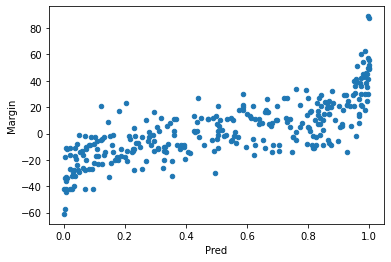

In [15]:
merged = prob_df.merge(tourney_results, on=["T1_TeamID", "T2_TeamID", "Season"])
merged.plot("Pred", "Margin", kind="scatter");


Looks much better and less noisy.

In [16]:
knn = KNeighborsRegressor()
param_grid = dict(n_neighbors=np.arange(1, 50))
clf = GridSearchCV(knn, param_grid)
clf.fit(merged.Pred.to_numpy().reshape(-1, 1), merged.Margin)
clf.best_index_

26

In [17]:
from google.colab import files
uploaded=files.upload()

Saving elo_2021-04-05.csv to elo_2021-04-05 (1).csv


In [18]:
from google.colab import files
uploaded=files.upload()

Saving elo_calibrated_margin_fix_season_merge.csv to elo_calibrated_margin_fix_season_merge.csv


In [19]:
stage2_df = pd.read_csv("elo_2021-04-05.csv")
pred_margin = clf.best_estimator_.predict(stage2_df.Pred.to_numpy().reshape(-1, 1))
stage2_df["Pred"] = pred_margin
stage2_df[["ID", "Pred"]].to_csv("elo_calibrated_margin_fix_season_merge.csv", index=False)

In [20]:
pred_results_combined = stage2_result.merge(stage2_df, on="ID", how="left")
print(f"Fixed score: {mean_squared_error(pred_results_combined.Margin, pred_results_combined.Pred, squared=False)}")

Fixed score: 11.104342441563457


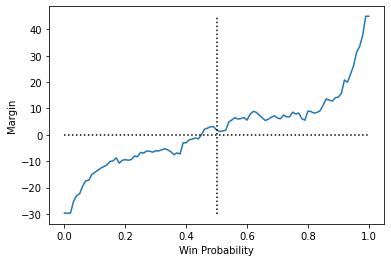

In [21]:
x = np.linspace(0, 1, 101)
pred = clf.best_estimator_.predict(x.reshape(-1, 1))
plt.plot(x, pred)
plt.xlabel("Win Probability")
plt.ylabel("Margin")
plt.hlines(0, 0, 1, linestyle="dotted", colors="k")
plt.vlines(0.5, -30, 45, linestyle="dotted", colors="k");

I noticed on submission that my model is asymmetric in its predicted margin. I had no time to do anything about it. I checked later and any attempt to symmetrize it I attempted after the deadline would have cost me first place.